## Setup

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
FORCE_CPU = False
SEED = 2384

HIDDEN_SIZE = 16
TASK_TRAIN_SIZE = 100000
TASK_TEST_SIZE = 1000
TASK_LR = 0.01
TASK_EPOCHS = 10000
TASK_SCHEDULER_PATIENCE = 1000

SAVE_MODEL = False
LOAD_MODEL = True
MODEL_PATH = "saved_models/hierarchical-equality.pt"

In [3]:
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px

from transformer_lens.hook_points import HookedRootModule, HookPoint

from causal_networks.dag import DeterministicDAG
from causal_networks.variable_alignment import VariableAlignment

In [4]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Training the model

In [5]:
@dataclass
class Config:
    input_size: int = 4
    hidden_size: int = 16
    output_size: int = 2

In [6]:
# Create a three layer hooked MLP
class MLP(HookedRootModule):
    def __init__(self, cfg: Config, device=None):
        super().__init__()

        if device is None:
            device = torch.device("cpu")

        self.device = device

        self.cfg = cfg

        self.hook_pre1 = HookPoint()
        self.layer1 = nn.Linear(cfg.input_size, cfg.hidden_size, bias=True, device=device)
        self.hook_mid1 = HookPoint()
        self.hook_pre2 = HookPoint()
        self.layer2 = nn.Linear(cfg.hidden_size, cfg.hidden_size, bias=True, device=device)
        self.hook_mid2 = HookPoint()
        self.hook_pre3 = HookPoint()
        self.layer3 = nn.Linear(cfg.hidden_size, cfg.output_size, bias=True, device=device)
        self.hook_mid3 = HookPoint()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.hook_pre1(x)
        x = self.hook_mid1(self.layer1(x))
        x = self.relu(x)
        x = self.hook_pre2(x)
        x = self.hook_mid2(self.layer2(x))
        x = self.relu(x)
        x = self.hook_pre3(x)
        x = self.hook_mid3(self.layer3(x))
        return x

In [7]:
# define the model
model = MLP(Config(hidden_size=HIDDEN_SIZE), device=device)
model.setup()

print(model)

MLP(
  (hook_pre1): HookPoint()
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (hook_mid1): HookPoint()
  (hook_pre2): HookPoint()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid2): HookPoint()
  (hook_pre3): HookPoint()
  (layer3): Linear(in_features=16, out_features=2, bias=True)
  (hook_mid3): HookPoint()
  (relu): ReLU()
)


In [8]:
def generate_grouped_data(n):
    """Generates n data points with 4 balanced groups,
       (w==x, y==z), (w==x, y!=z), (w!=x, y==z), (w!=x, y!=z)
       For the heirarchical equality task""" 
    
    # Initialize the empty list for data and labels
    data, labels = [], []
    for i in range(n):
        # Define a pattern for each group based on the remainder when i is divided by 4
        group_pattern = i % 4
        
        # Depending on the pattern, generate w, x, y, z
        if group_pattern == 0:  # w==x, y!=z
            w = x = np.random.uniform(-0.5, 0.5)
            y, z = np.random.uniform(-0.5, 0.5, 2)
        elif group_pattern == 1:  # w==x, y==z
            w = x = np.random.uniform(-0.5, 0.5)
            y = z = np.random.uniform(-0.5, 0.5)
        elif group_pattern == 2:  # w!=x, y==z
            w, x = np.random.uniform(-0.5, 0.5, 2)
            y = z = np.random.uniform(-0.5, 0.5)
        elif group_pattern == 3:  # w!=x, y!=z
            w, x, y, z = np.random.uniform(-0.5, 0.5, 4)
        
        # Decide the label based on the given condition
        label = 1 if (w == x) == (y == z) else 0

        # Append the generated data and label to the respective lists
        data.append([w, x, y, z])
        labels.append(label)

    # Convert the lists to numpy arrays for further processing
    data = np.array(data)
    labels = np.array(labels)

    return data, labels


In [9]:
# generate the data
data, labels = generate_grouped_data(100000)

In [10]:
# train the network

# set the random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

val_data, val_labels = generate_grouped_data(TASK_TEST_SIZE)
val_data = torch.from_numpy(val_data).float()
val_labels = torch.from_numpy(val_labels).long()

if LOAD_MODEL:

    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

else:

    # define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=TASK_LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=TASK_SCHEDULER_PATIENCE, verbose=True)

    # convert the data and labels to torch tensors
    data, labels = generate_grouped_data(TASK_TRAIN_SIZE)
    data = torch.from_numpy(data).float()
    labels = torch.from_numpy(labels).long()

    data = data.to(device)
    labels = labels.to(device)
    val_data = val_data.to(device)
    val_labels = val_labels.to(device)
    model = model.to(device)

    # train the model
    for epoch in range(TASK_EPOCHS):
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        if (epoch+1) % 100 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, TASK_EPOCHS, loss.item()))

# test the model
with torch.no_grad():
    val_data = val_data.to(device)
    val_labels = val_labels.to(device)
    outputs = model(val_data)
    _, predicted = torch.max(outputs.data, 1)

    # compute the accuracy
    total = val_labels.size(0)
    correct = (predicted == val_labels).sum().item()
    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))

Accuracy of the network on the test data: 98.5 %


In [11]:
if SAVE_MODEL:
    torch.save(model.state_dict(), MODEL_PATH)

## Causal DAGS

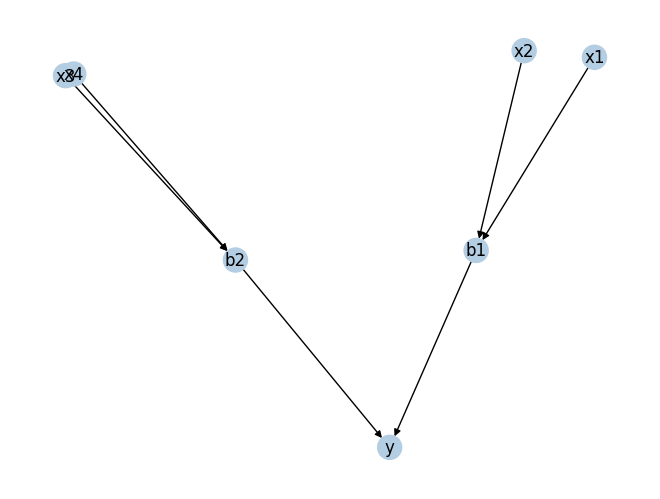

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ -     │
│ x2   │ -            │ float_sampler │ float_validator │ -     │
│ x3   │ -            │ float_sampler │ float_validator │ -     │
│ x4   │ -            │ float_sampler │ float_validator │ -     │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ -     │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [12]:
def float_validator(value):
    return -0.5 <= value <= 0.5

def float_sampler():
    return random.uniform(-0.5, 0.5)

def bool_validator(value):
    return value in {True, False}

def bool_sampler():
    return random.choice([True, False])

def copy_func(x):
    return x

def compare_func(value1, value2):
    return value1 == value2

dag = DeterministicDAG()

# Define the nodes
dag.add_node('x1', validator=float_validator, sampler=float_sampler)
dag.add_node('x2', validator=float_validator, sampler=float_sampler)
dag.add_node('x3', validator=float_validator, sampler=float_sampler)
dag.add_node('x4', validator=float_validator, sampler=float_sampler)
dag.add_node('b1', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag.add_node('b2', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag.add_node('y', func=compare_func, validator=bool_validator, sampler=bool_sampler, possible_values=[False, True])

# Define the edges
edges = [('x1', 'b1'), ('x2', 'b1'), ('x3', 'b2'), ('x4', 'b2'), 
         ('b1', 'y'), ('b2', 'y')]
for edge in edges:
    dag.add_edge(*edge)

dag.visualize()

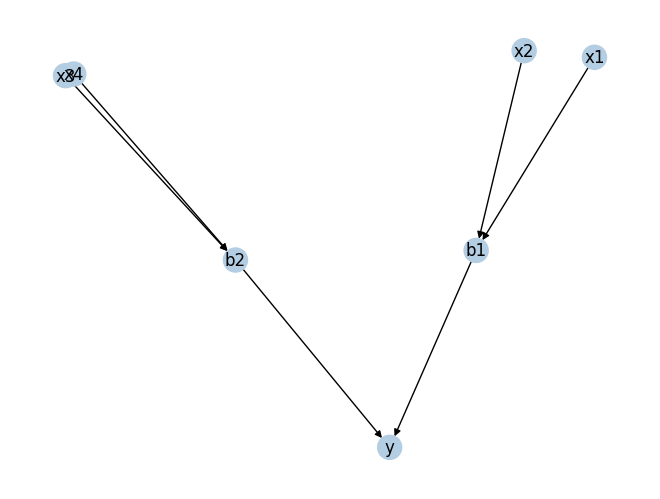

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ 0.1   │
│ x2   │ -            │ float_sampler │ float_validator │ 0.2   │
│ x3   │ -            │ float_sampler │ float_validator │ 0.3   │
│ x4   │ -            │ float_sampler │ float_validator │ 0.4   │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ True  │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [13]:
dag.run(dict(x1=0.1, x2=0.2, x3=0.3, x4=0.4))
dag.visualize()

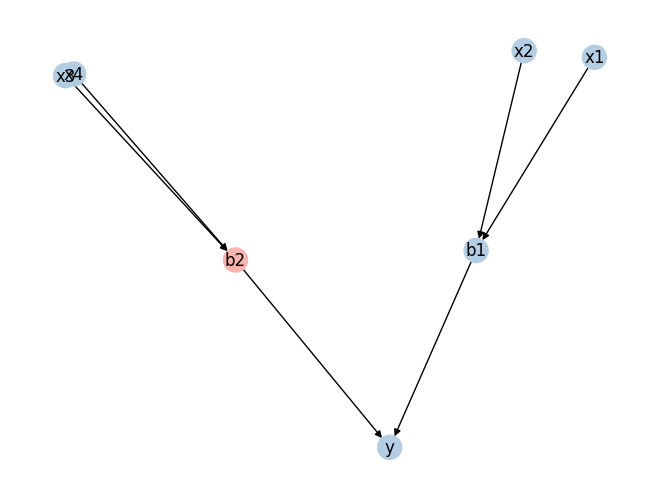

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ 0.1   │
│ x2   │ -            │ float_sampler │ float_validator │ 0.2   │
│ x3   │ -            │ float_sampler │ float_validator │ 0.3   │
│ x4   │ -            │ float_sampler │ float_validator │ 0.4   │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ True  │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ False │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [14]:
dag.intervene_and_run("b2", True, dict(x1=0.1, x2=0.2, x3=0.3, x4=0.4))
dag.visualize()

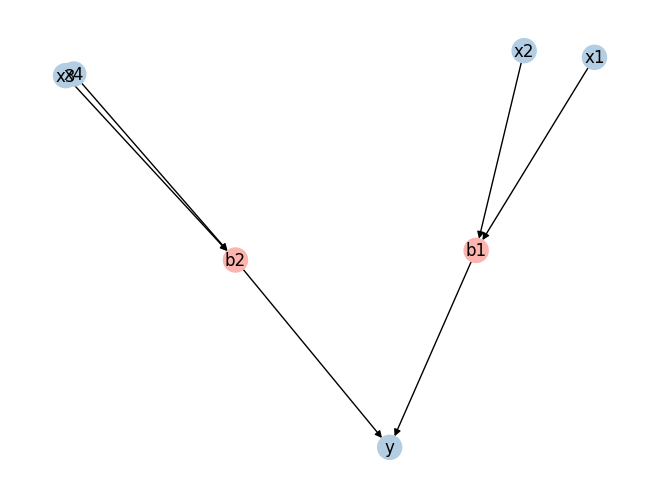

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ -     │
│ x2   │ -            │ float_sampler │ float_validator │ -     │
│ x3   │ -            │ float_sampler │ float_validator │ -     │
│ x4   │ -            │ float_sampler │ float_validator │ -     │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ True  │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ -     │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [15]:
dag.do_interchange_intervention(
    [["b1"], ["b2"]],
    [dict(x1=0.1, x2=0.1, x3=0.1, x4=0.1), dict(x1=0.5, x2=0.4, x3=0.3, x4=0.2)],
)
dag.visualize()

## Variable alignment

In [16]:
model

MLP(
  (hook_pre1): HookPoint()
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (hook_mid1): HookPoint()
  (hook_pre2): HookPoint()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid2): HookPoint()
  (hook_pre3): HookPoint()
  (layer3): Linear(in_features=16, out_features=2, bias=True)
  (hook_mid3): HookPoint()
  (relu): ReLU()
)

In [17]:
def input_alignment(x: torch.tensor):
    if x.ndim == 1:
        return dict(x1=x[0].item(), x2=x[1].item(), x3=x[2].item(), x4=x[3].item())
    elif x.ndim == 2 and x.shape[0] == 1:
        return [dict(x1=x[0, 0].item(), x2=x[0, 1].item(), x3=x[0, 2].item(), x4=x[0, 3].item())]
    elif x.ndim == 2:
        return [
            dict(
                x1=x[i, 0].item(),
                x2=x[i, 1].item(),
                x3=x[i, 2].item(),
                x4=x[i, 3].item(),
            )
            for i in range(x.shape[0])
        ]
    else:
        raise ValueError("Invalid input shape")


def output_alignment(y: torch.tensor):
    return dict(y=torch.argmax(y).item())


variable_alignment = VariableAlignment(
    dag=dag,
    low_level_model=model,
    dag_nodes=["b1", "b2"],
    input_alignment=input_alignment,
    output_alignment=output_alignment,
    intervene_model_hooks=["hook_pre2"],
    subspaces_sizes=[8, 8],
    verbosity=1,
)

Running model to determine activation space size...


In [18]:
# base_input = torch.rand(1, 4) - 0.5
# source_inputs = torch.rand(2, 4) - 0.5
# variable_alignment.get_distributed_interchange_intervention_hooks(base_input, source_inputs)

In [19]:
# variable_alignment.run_distributed_interchange_intervention(base_input, source_inputs)

In [20]:
# variable_alignment.run_interchange_intervention(base_input, source_inputs)

In [21]:
# variable_alignment.dii_training_objective_and_agreement(base_input, source_inputs)

## Intervention intervention training

In [22]:
inputs, _ = generate_grouped_data(10000)
inputs = torch.tensor(inputs, dtype=torch.float32)

In [23]:
variable_alignment.dag_nodes

['b1', 'b2']

In [24]:
ii_dataset = variable_alignment.create_interchange_intervention_dataset(inputs, num_samples=1000000)

In [25]:
losses, accuracies = variable_alignment.train_rotation_matrix(ii_dataset=ii_dataset, num_epochs=100, batch_size=16000)

Epoch [1/100]: 100%|██████████| 63/63 [00:09<00:00,  6.77it/s]


Loss: 35.16192, Accuracy: 0.60780


Epoch [2/100]: 100%|██████████| 63/63 [00:09<00:00,  6.96it/s]


Loss: 25.81614, Accuracy: 0.63148


Epoch [3/100]: 100%|██████████| 63/63 [00:09<00:00,  6.97it/s]


Loss: 23.75536, Accuracy: 0.63855


Epoch [4/100]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Loss: 22.60542, Accuracy: 0.63441


Epoch [5/100]: 100%|██████████| 63/63 [00:08<00:00,  7.02it/s]


Loss: 21.86370, Accuracy: 0.63554


Epoch [6/100]: 100%|██████████| 63/63 [00:08<00:00,  7.12it/s]


Loss: 21.31360, Accuracy: 0.63729


Epoch [7/100]: 100%|██████████| 63/63 [00:08<00:00,  7.07it/s]


Loss: 20.86314, Accuracy: 0.64277


Epoch [8/100]: 100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Loss: 20.49157, Accuracy: 0.64614


Epoch [9/100]: 100%|██████████| 63/63 [00:09<00:00,  6.99it/s]


Loss: 20.19422, Accuracy: 0.64930


Epoch [10/100]: 100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Loss: 19.92132, Accuracy: 0.65297


Epoch [11/100]: 100%|██████████| 63/63 [00:09<00:00,  6.95it/s]


Loss: 19.71779, Accuracy: 0.65557


Epoch [12/100]: 100%|██████████| 63/63 [00:09<00:00,  6.97it/s]


Loss: 19.51111, Accuracy: 0.65818


Epoch [13/100]: 100%|██████████| 63/63 [00:09<00:00,  6.95it/s]


Loss: 19.36559, Accuracy: 0.66006


Epoch [14/100]: 100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Loss: 19.18386, Accuracy: 0.66180


Epoch [15/100]: 100%|██████████| 63/63 [00:08<00:00,  7.01it/s]


Loss: 19.04351, Accuracy: 0.66322


Epoch [16/100]: 100%|██████████| 63/63 [00:09<00:00,  6.93it/s]


Loss: 18.93344, Accuracy: 0.66376


Epoch [17/100]: 100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Loss: 18.80606, Accuracy: 0.66513


Epoch [18/100]: 100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Loss: 18.70768, Accuracy: 0.66581


Epoch [19/100]: 100%|██████████| 63/63 [00:09<00:00,  6.96it/s]


Loss: 18.61791, Accuracy: 0.66675


Epoch [20/100]: 100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Loss: 18.52570, Accuracy: 0.66746


Epoch [21/100]: 100%|██████████| 63/63 [00:09<00:00,  6.96it/s]


Loss: 18.45394, Accuracy: 0.66737


Epoch [22/100]: 100%|██████████| 63/63 [00:09<00:00,  6.79it/s]


Loss: 18.38785, Accuracy: 0.66834


Epoch [23/100]: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Loss: 18.23417, Accuracy: 0.66940


Epoch [24/100]: 100%|██████████| 63/63 [00:08<00:00,  7.02it/s]


Loss: 18.30051, Accuracy: 0.66875


Epoch [25/100]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Loss: 18.18097, Accuracy: 0.66955


Epoch [26/100]: 100%|██████████| 63/63 [00:09<00:00,  6.80it/s]


Loss: 18.20588, Accuracy: 0.66931


Epoch [27/100]: 100%|██████████| 63/63 [00:09<00:00,  6.93it/s]


Loss: 18.02082, Accuracy: 0.67107


Epoch [28/100]: 100%|██████████| 63/63 [00:09<00:00,  6.85it/s]


Loss: 18.11396, Accuracy: 0.66998


Epoch [29/100]: 100%|██████████| 63/63 [00:09<00:00,  6.92it/s]


Loss: 18.09287, Accuracy: 0.67022


Epoch [30/100]: 100%|██████████| 63/63 [00:09<00:00,  6.82it/s]


Loss: 17.98760, Accuracy: 0.67133


Epoch [31/100]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Loss: 17.96693, Accuracy: 0.67140


Epoch [32/100]: 100%|██████████| 63/63 [00:09<00:00,  6.85it/s]


Loss: 17.94619, Accuracy: 0.67160


Epoch [33/100]: 100%|██████████| 63/63 [00:09<00:00,  6.79it/s]


Loss: 17.92568, Accuracy: 0.67164


Epoch [34/100]: 100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Loss: 17.90219, Accuracy: 0.67186


Epoch [35/100]: 100%|██████████| 63/63 [00:09<00:00,  6.93it/s]


Loss: 17.88065, Accuracy: 0.67214


Epoch [36/100]: 100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Loss: 17.85882, Accuracy: 0.67231


Epoch [37/100]: 100%|██████████| 63/63 [00:09<00:00,  6.90it/s]


Loss: 17.83566, Accuracy: 0.67255


Epoch [38/100]: 100%|██████████| 63/63 [00:09<00:00,  6.82it/s]


Loss: 17.81754, Accuracy: 0.67267


Epoch [39/100]: 100%|██████████| 63/63 [00:09<00:00,  6.99it/s]


Loss: 17.79704, Accuracy: 0.67296


Epoch [40/100]: 100%|██████████| 63/63 [00:09<00:00,  6.84it/s]


Loss: 17.78062, Accuracy: 0.67302


Epoch [41/100]: 100%|██████████| 63/63 [00:08<00:00,  7.05it/s]


Loss: 17.77113, Accuracy: 0.67296


Epoch [42/100]: 100%|██████████| 63/63 [00:09<00:00,  6.99it/s]


Loss: 17.75099, Accuracy: 0.67328


Epoch [43/100]: 100%|██████████| 63/63 [00:09<00:00,  6.95it/s]


Loss: 17.72563, Accuracy: 0.67331


Epoch [44/100]: 100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Loss: 17.70453, Accuracy: 0.67365


Epoch [45/100]: 100%|██████████| 63/63 [00:09<00:00,  6.93it/s]


Loss: 17.68896, Accuracy: 0.67376


Epoch [46/100]: 100%|██████████| 63/63 [00:09<00:00,  6.75it/s]


Loss: 17.67994, Accuracy: 0.67379


Epoch [47/100]: 100%|██████████| 63/63 [00:08<00:00,  7.08it/s]


Loss: 17.66049, Accuracy: 0.67397


Epoch [48/100]: 100%|██████████| 63/63 [00:09<00:00,  6.96it/s]


Loss: 17.64591, Accuracy: 0.67406


Epoch [49/100]: 100%|██████████| 63/63 [00:09<00:00,  6.82it/s]


Loss: 17.63698, Accuracy: 0.67413


Epoch [50/100]: 100%|██████████| 63/63 [00:09<00:00,  6.75it/s]


Loss: 17.62132, Accuracy: 0.67422


Epoch [51/100]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Loss: 17.61114, Accuracy: 0.67426


Epoch [52/100]: 100%|██████████| 63/63 [00:09<00:00,  6.94it/s]


Loss: 17.59180, Accuracy: 0.67450


Epoch [53/100]: 100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Loss: 17.57839, Accuracy: 0.67462


Epoch [54/100]: 100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Loss: 17.57137, Accuracy: 0.67469


Epoch [55/100]: 100%|██████████| 63/63 [00:09<00:00,  6.98it/s]


Loss: 17.56230, Accuracy: 0.67456


Epoch [56/100]: 100%|██████████| 63/63 [00:09<00:00,  6.81it/s]


Loss: 17.53944, Accuracy: 0.67493


Epoch [57/100]: 100%|██████████| 63/63 [00:09<00:00,  6.92it/s]


Loss: 17.53648, Accuracy: 0.67493


Epoch [58/100]: 100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Loss: 17.44853, Accuracy: 0.67533


Epoch [59/100]: 100%|██████████| 63/63 [00:08<00:00,  7.26it/s]


Loss: 17.55033, Accuracy: 0.67474


Epoch [60/100]: 100%|██████████| 63/63 [00:08<00:00,  7.16it/s]


Loss: 17.51198, Accuracy: 0.67488


Epoch [61/100]: 100%|██████████| 63/63 [00:08<00:00,  7.09it/s]


Loss: 17.50901, Accuracy: 0.67504


Epoch [62/100]: 100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Loss: 17.49286, Accuracy: 0.67519


Epoch [63/100]: 100%|██████████| 63/63 [00:08<00:00,  7.04it/s]


Loss: 17.42999, Accuracy: 0.67526


Epoch [64/100]: 100%|██████████| 63/63 [00:08<00:00,  7.03it/s]


Loss: 17.53761, Accuracy: 0.67471


Epoch [65/100]: 100%|██████████| 63/63 [00:08<00:00,  7.12it/s]


Loss: 17.39292, Accuracy: 0.67536


Epoch [66/100]: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Loss: 17.52675, Accuracy: 0.67460


Epoch [67/100]: 100%|██████████| 63/63 [00:09<00:00,  6.95it/s]


Loss: 17.39728, Accuracy: 0.67560


Epoch [68/100]: 100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Loss: 17.40878, Accuracy: 0.67521


Epoch [69/100]: 100%|██████████| 63/63 [00:09<00:00,  6.63it/s]


Loss: 17.50792, Accuracy: 0.67499


Epoch [70/100]: 100%|██████████| 63/63 [00:10<00:00,  5.87it/s]


Loss: 17.37123, Accuracy: 0.67574


Epoch [71/100]: 100%|██████████| 63/63 [00:10<00:00,  5.86it/s]


Loss: 17.44226, Accuracy: 0.67473


Epoch [72/100]: 100%|██████████| 63/63 [00:10<00:00,  5.99it/s]


Loss: 17.40946, Accuracy: 0.67511


Epoch [73/100]: 100%|██████████| 63/63 [00:10<00:00,  6.00it/s]


Loss: 17.44124, Accuracy: 0.67515


Epoch [74/100]: 100%|██████████| 63/63 [00:10<00:00,  5.90it/s]


Loss: 17.40086, Accuracy: 0.67499


Epoch [75/100]: 100%|██████████| 63/63 [00:12<00:00,  5.14it/s]


Loss: 17.43089, Accuracy: 0.67528


Epoch [76/100]: 100%|██████████| 63/63 [00:12<00:00,  5.18it/s]


Loss: 17.36932, Accuracy: 0.67534


Epoch [77/100]: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]


Loss: 17.37043, Accuracy: 0.67504


Epoch [78/100]: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]


Loss: 17.43533, Accuracy: 0.67515


Epoch [79/100]: 100%|██████████| 63/63 [00:10<00:00,  5.83it/s]


Loss: 17.37768, Accuracy: 0.67504


Epoch [80/100]: 100%|██████████| 63/63 [00:11<00:00,  5.72it/s]


Loss: 17.42393, Accuracy: 0.67538


Epoch [81/100]: 100%|██████████| 63/63 [00:11<00:00,  5.64it/s]


Loss: 17.35839, Accuracy: 0.67503


Epoch [82/100]: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]


Loss: 17.42420, Accuracy: 0.67531


Epoch [83/100]: 100%|██████████| 63/63 [00:11<00:00,  5.69it/s]


Loss: 17.35711, Accuracy: 0.67503


Epoch [84/100]: 100%|██████████| 63/63 [00:11<00:00,  5.60it/s]


Loss: 17.41557, Accuracy: 0.67534


Epoch [85/100]: 100%|██████████| 63/63 [00:11<00:00,  5.64it/s]


Loss: 17.35484, Accuracy: 0.67529


Epoch [86/100]: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]


Loss: 17.40837, Accuracy: 0.67527


Epoch [87/100]: 100%|██████████| 63/63 [00:10<00:00,  5.74it/s]


Loss: 17.35051, Accuracy: 0.67541


Epoch [88/100]: 100%|██████████| 63/63 [00:10<00:00,  5.74it/s]


Loss: 17.40103, Accuracy: 0.67537


Epoch [89/100]: 100%|██████████| 63/63 [00:11<00:00,  5.69it/s]


Loss: 17.32851, Accuracy: 0.67547


Epoch [90/100]: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]


Loss: 17.34787, Accuracy: 0.67518


Epoch [91/100]: 100%|██████████| 63/63 [00:11<00:00,  5.70it/s]


Loss: 17.39634, Accuracy: 0.67530


Epoch [92/100]: 100%|██████████| 63/63 [00:11<00:00,  5.71it/s]


Loss: 17.34265, Accuracy: 0.67516


Epoch [93/100]: 100%|██████████| 63/63 [00:11<00:00,  5.69it/s]


Loss: 17.39114, Accuracy: 0.67535


Epoch [94/100]: 100%|██████████| 63/63 [00:11<00:00,  5.60it/s]


Loss: 17.33756, Accuracy: 0.67541


Epoch [95/100]: 100%|██████████| 63/63 [00:10<00:00,  5.74it/s]


Loss: 17.38524, Accuracy: 0.67529


Epoch [96/100]: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]


Loss: 17.33479, Accuracy: 0.67538


Epoch [97/100]: 100%|██████████| 63/63 [00:11<00:00,  5.67it/s]


Loss: 17.37644, Accuracy: 0.67514


Epoch [98/100]: 100%|██████████| 63/63 [00:11<00:00,  5.60it/s]


Loss: 17.30935, Accuracy: 0.67551


Epoch [99/100]: 100%|██████████| 63/63 [00:10<00:00,  5.76it/s]


Loss: 17.33896, Accuracy: 0.67522


Epoch [100/100]: 100%|██████████| 63/63 [00:10<00:00,  5.75it/s]

Loss: 17.37018, Accuracy: 0.67541


In [26]:
px.line(y=losses, title="Loss", labels={"x": "Epoch", "y": "Loss"})

In [27]:
px.line(y=accuracies, title="Accuracies", labels={"x": "Epoch", "y": "Accuracy"})

## Dummy testing

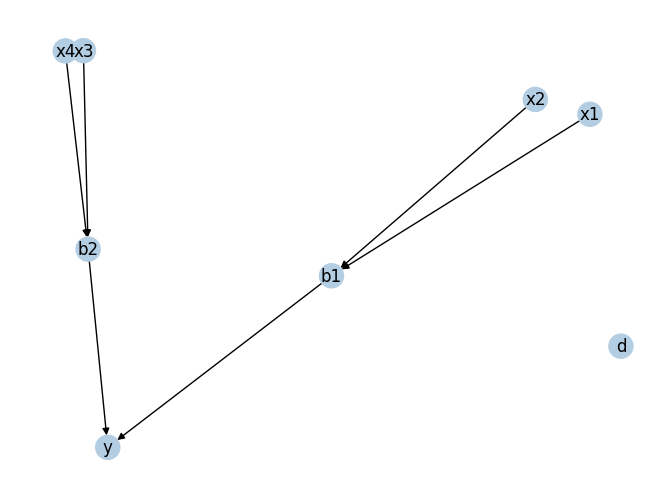

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ -     │
│ x2   │ -            │ float_sampler │ float_validator │ -     │
│ x3   │ -            │ float_sampler │ float_validator │ -     │
│ x4   │ -            │ float_sampler │ float_validator │ -     │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ d    │ <lambda>     │ bool_sampler  │ <lambda>        │ -     │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [28]:
dag2 = DeterministicDAG()

# Define the nodes
dag2.add_node('x1', validator=float_validator, sampler=float_sampler)
dag2.add_node('x2', validator=float_validator, sampler=float_sampler)
dag2.add_node('x3', validator=float_validator, sampler=float_sampler)
dag2.add_node('x4', validator=float_validator, sampler=float_sampler)
dag2.add_node('b1', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag2.add_node('b2', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag2.add_node('y', func=compare_func, validator=bool_validator, sampler=bool_sampler, possible_values=[False, True])
dag2.add_node('d', func=lambda x: True, validator=lambda x: True, sampler=bool_sampler, possible_values=[True, False, None])

# Define the edges
edges = [('x1', 'b1'), ('x2', 'b1'), ('x3', 'b2'), ('x4', 'b2'), 
         ('b1', 'y'), ('b2', 'y')]
for edge in edges:
    dag2.add_edge(*edge)

dag2.visualize()

In [29]:
variable_alignment2 = VariableAlignment(
    dag=dag2,
    low_level_model=model,
    dag_nodes=["d"],
    input_alignment=input_alignment,
    output_alignment=output_alignment,
    intervene_model_hooks=["hook_pre2"],
    subspaces_sizes=[1],
    verbosity=1,
)

Running model to determine activation space size...


In [30]:
losses, accuracies = variable_alignment2.train_rotation_matrix(inputs, num_samples=1000, num_epochs=5)

Creating interchange intervention dataset...


Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 88.45it/s]


Loss: 5.40357, Accuracy: 0.89355


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 91.16it/s]


Loss: 0.12193, Accuracy: 0.97656


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 96.41it/s]


Loss: 0.08561, Accuracy: 0.97852


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 95.03it/s]


Loss: 0.05476, Accuracy: 0.98340


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 91.56it/s]

Loss: 0.04901, Accuracy: 0.98340
